<a href="https://colab.research.google.com/github/GodJiLee/Dacon/blob/main/%EA%B5%AC%EB%82%B4%EC%8B%9D%EB%8B%B9%20%EC%8B%9D%EC%88%98%EC%9D%B8%EC%9B%90%20%EC%98%88%EC%B8%A1/90_586366_LGBM_%EA%B5%AC%EB%82%B4%EC%8B%9D%EB%8B%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **To Do List**
1. 월/일/요일 팩터화
2. XGBoost + GridSearch 조합 외에 다른 모델 적용하기 (예측 모델: LGBMRegressor, ...) (O)
3. 공유코드 4, word embedding feature 결합하기 (O)
4. parameter 최적화하기 (추가)
5. 휴가자 수, 재택 근무자 수 빼지 않고 모델에 포함시켜보기 (O)

---








# **2. 한글 패치 (matplotlib)**

In [ ]:
# Step 1. Matplotlib 업그레이드
!pip install matplotlib -U

# Step 2. 한글 설치 및 사용 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# Step 3. 런타임 재시작

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.2)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleanin

In [ ]:
# Step 4. 한글 글꼴 설정
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = ['NanumGothic', 'sans-serif'] # 차트의 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

# **3. 기타 설정 (임포트 등)**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# 경고 제어
warnings.filterwarnings(action = 'ignore') # 경고를 출력하지 않음

# **4. 데이터 불러오기**

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon_contest1/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon_contest1/data/test.csv')

# **5. 데이터 정제 (Dtype: object)**

1. 조식, 중식, 석식 메뉴는 버리기 (drop)
2. 일자, 요일은 라벨 인코딩 (숫자형으로 변환)

## **1. 조식, 중식, 석식 메뉴는 버리기 (drop)**

In [ ]:
# drops = ['조식메뉴']

# train = train.drop(drops, axis = 1) # axis = 1은 열을 의미 (열삭제)
# test = test.drop(drops, axis = 1)

## **2. 일자, 요일은 라벨 인코딩 (숫자형으로 변환)**

In [ ]:
# 월, 일 인코딩
train['연'] = pd.DatetimeIndex(train['일자']).year
test['연'] = pd.DatetimeIndex(test['일자']).year

train['월'] = pd.DatetimeIndex(train['일자']).month
test['월'] = pd.DatetimeIndex(test['일자']).month

train['일'] = pd.DatetimeIndex(train['일자']).day
test['일'] = pd.DatetimeIndex(test['일자']).day

In [ ]:
# 요일 인코딩
# 팩터화 해야 하는거 아니야...?
weekday = {
    '월': 1,
    '화': 2,
    '수': 3,
    '목': 4,
    '금': 5
}

train['요일'] = train['요일'].map(weekday)
test['요일'] = test['요일'].map(weekday)

# **6. 데이터 정제 (아이디어)**

* 휴가자, 재택근무자는 중식/석식에 참여하지 않을 것이므로 본사 정원수에서 차감한다.
* 즉, 본사정원수 - 휴가자 - 재택근무자
* 식사참여율 = 식사계 / 식사가능자수

In [ ]:
train['식사가능자수'] = train['본사정원수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
test['식사가능자수'] = test['본사정원수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

In [ ]:
# 식사가능자수 float -> int로 변경
train['식사가능자수'] = train['식사가능자수'].astype('int')
test['식사가능자수'] = test['식사가능자수'].astype('int')

In [ ]:
train['중식참여율'] = train['중식계'] / train['식사가능자수']
train['석식참여율'] = train['석식계'] / train['식사가능자수']

정제한 데이터를 정리하면,

### **요일(석식) 컬럼 만들기**

In [ ]:
# 요일을 석식 rank에 맞춰 mapping한 요일(석식) 컬럼 만들기
# train 데이터만의 특징일 수 있지 않을까..?
weekday_rank4dinner = {
    1: 1,
    2: 2,
    3: 5,
    4: 3,
    5: 4,
}

train['요일(석식)'] = train['요일'].map(weekday_rank4dinner)
test['요일(석식)'] = test['요일'].map(weekday_rank4dinner)

In [ ]:
# features는 학습시킬 특성값들, labels는 추론할 대상값들
features = ['연', '월', '일', '요일', '식사가능자수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴']
labels = ['중식계', '석식계'] # '중식참여율', '석식참여율'

train = train[features + labels]
test = test[features]

## **7. EDA, 시각화, 상관관계분석**
1. 히트맵
2. 라인그래프

### **1. 히트맵**

In [ ]:
train.corr()[['중식계', '석식계']]

,중식계,석식계
월,-0.154664,-0.127142
일,-0.097392,-0.185565
요일,-0.731563,-0.312112
식사가능자수,0.151029,0.118615
본사출장자수,-0.512680,-0.188164
본사시간외근무명령서승인건수,0.535611,0.571168
중식계,1.000000,0.508287
석식계,0.508287,1.000000
중식참여율,0.957156,0.475360
석식참여율,0.479768,0.973722


In [ ]:
sns.heatmap(train.corr()[['중식계', '석식계']])

* 중식
1. 요일
2. 본사시간외근무명령서승인건수
3. 본사출장자수

* 석식
1. 본사시간외근무명령서승인건수
2. 요일
3. 본사출장자수

In [ ]:
train.corr()[['중식참여율', '석식참여율']]

,중식참여율,석식참여율
월,-0.166198,-0.139499
일,-0.100648,-0.186355
요일,-0.697276,-0.284943
식사가능자수,-0.133553,-0.097914
본사출장자수,-0.618408,-0.267198
본사시간외근무명령서승인건수,0.473097,0.518348
중식계,0.957156,0.479768
석식계,0.475360,0.973722
중식참여율,1.000000,0.511255
석식참여율,0.511255,1.000000


In [ ]:
sns.heatmap(train.corr()[['중식참여율', '석식참여율']])

In [ ]:
train.corr()['중식참여율'].sort_values()

요일               -0.697276
본사출장자수           -0.618408
월                -0.166198
식사가능자수           -0.133553
일                -0.100648
본사시간외근무명령서승인건수    0.473097
석식계               0.475360
석식참여율             0.511255
중식계               0.957156
중식참여율             1.000000
Name: 중식참여율, dtype: float64

In [ ]:
train.corr()['석식참여율'].sort_values()

요일               -0.284943
본사출장자수           -0.267198
일                -0.186355
월                -0.139499
식사가능자수           -0.097914
중식계               0.479768
중식참여율             0.511255
본사시간외근무명령서승인건수    0.518348
석식계               0.973722
석식참여율             1.000000
Name: 석식참여율, dtype: float64

## **2. 라인그래프**
1. 요일
2. 월 (yet)
3. 일 (yet)

### **1. 요일**

In [ ]:
# 요일별 features, labels 추이 확인
fig, ax = plt.subplots(7)
fig.set_size_inches(10, 12)

sns.lineplot(data = train, x = '요일', y = '식사가능자수', ax = ax[0]) # ax는 plot에서 그림을 그릴 위치
sns.lineplot(data = train, x = '요일', y = '본사출장자수', ax = ax[1])
sns.lineplot(data = train, x = '요일', y = '본사시간외근무명령서승인건수', ax = ax[2])
sns.lineplot(data = train, x = '요일', y = '중식계', ax = ax[3])
sns.lineplot(data = train, x = '요일', y = '석식계', ax = ax[4])
sns.lineplot(data = train, x = '요일', y = '중식참여율', ax = ax[5])
sns.lineplot(data = train, x = '요일', y = '석식참여율', ax = ax[6])

요일별 데이터에서
* 중식계는 본사출장자수와 반비례 관계,
* 석식계는 본사시간외근무명령서승인건수와 정비례 관계로 밀접해 보임.

### **2. 월**

In [ ]:
# 월별 features, labels 추이 확인
# 월별로 보니 상관성이 떨어짐 (계절타나..?)
fig, ax = plt.subplots(7)
fig.set_size_inches(10, 12)

sns.lineplot(data = train, x = '월', y = '식사가능자수', ax = ax[0])
sns.lineplot(data = train, x = '월', y = '본사출장자수', ax = ax[1])
sns.lineplot(data = train, x = '월', y = '본사시간외근무명령서승인건수', ax = ax[2])
sns.lineplot(data = train, x = '월', y = '중식계', ax = ax[3])
sns.lineplot(data = train, x = '월', y = '석식계', ax = ax[4])
sns.lineplot(data = train, x = '월', y = '중식참여율', ax = ax[5])
sns.lineplot(data = train, x = '월', y = '석식참여율', ax = ax[6])

<AxesSubplot:xlabel='일', ylabel='석식참여율'>

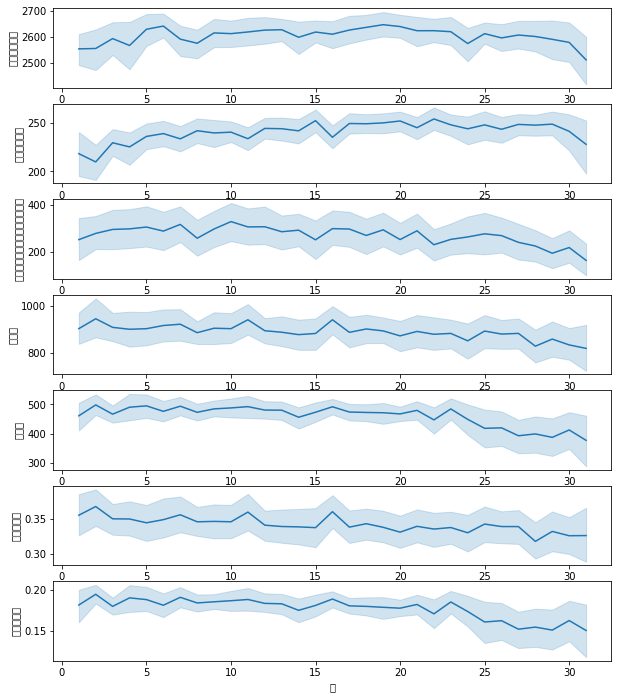

In [ ]:
fig, ax = plt.subplots(7)
fig.set_size_inches(10, 12)

sns.lineplot(data = train, x = '일', y = '식사가능자수', ax = ax[0])
sns.lineplot(data = train, x = '일', y = '본사출장자수', ax = ax[1])
sns.lineplot(data = train, x = '일', y = '본사시간외근무명령서승인건수', ax = ax[2])
sns.lineplot(data = train, x = '일', y = '중식계', ax = ax[3])
sns.lineplot(data = train, x = '일', y = '석식계', ax = ax[4])
sns.lineplot(data = train, x = '일', y = '중식참여율', ax = ax[5])
sns.lineplot(data = train, x = '일', y = '석식참여율', ax = ax[6])

### **8-1. Word Embedding**



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder # 수치형 자료가 아닌 자료에 대해 모델 학습을 위해 정수형으로 바꿔주는 기능
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor # Tree 기반 학습 알고리즘 (Gradient Boosting 프레임워크)

from gensim.models import Word2Vec
from gensim.models import KeyedVectors # 워드 벡터를 저장하고 관리하는 기능, 유사성 조회
from sklearn.manifold import TSNE # PCA 기반 차원 축소의 문제를 해결하기 위한 방법 (티스니)
from sklearn.decomposition import PCA

In [ ]:
# Hyper Parameter
class CFG:
    emb_dim = 200

args = CFG

In [ ]:
df_all = pd.concat([test, train]) # train, test 모두 사용 (data leakage 문제)

In [ ]:
# Basic text preprocessing
def split_process(x, q):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        
        if '/' in i:
            x_.extend(i.split('/')) # 리스트 풀어서 할당 (append와 다른 점)
        
        else:
            x_.append(i)
    
    x_ = list(set(x_))
    x_.remove('')
    return x_

In [ ]:
# Get all combinations for training w2v (train + test)
# 기존 조식 메뉴는 제거함
food_combinations = []
for i in ['중식메뉴', '석식메뉴']:
    food_combinations += df_all[i].apply(lambda x: split_process(x, i)).to_list() # 중식, 석식 메뉴를 모두 메뉴 단위로 split해서 리스트로 만듦

In [ ]:
food_combinations

[['흑미밥',
  '양상추샐러드*딸기D',
  '대구지리',
  '상추무침',
  '매운돈갈비찜',
  '찰현미밥',
  '오꼬노미계란말이',
  '쌀밥',
  '포기김치'],
 ['수제삼색무쌈',
  '오리주물럭',
  '우렁된장찌개',
  '양상추샐러드*오미자D',
  '보리밥',
  '겉절이김치',
  '청양부추전',
  '찰현미밥',
  '쌀밥'],
 ['흑미밥',
  '팽이장국',
  '가자미조림',
  '양상추샐러드*파인요거트D',
  '동초나물무침',
  '찰현미밥',
  '수제돈까스*소스',
  '쌀밥',
  '포기김치'],
 ['흑미밥',
  '시금치프리타타',
  '부추고추장무침',
  '배추들깨국',
  '양상추샐러드*망고D',
  '오리대패불고기',
  '찰현미밥',
  '쌀밥',
  '포기김치'],
 ['버섯탕수',
  '양상추샐러드*오리엔탈D',
  '닭살데리야끼조림',
  '사과푸딩',
  '알타리김치',
  '부대찌개',
  '찰현미밥',
  '팥밥',
  '쌀밥',
  '세발나물무침'],
 ['미나리나물', '감자조림', '흑미밥', '매콤해물볶음', '콥샐러드*렌치D', '아욱국', '찰현미밥', '쌀밥', '포기김치'],
 ['설렁탕',
  '고등어김치말이찜',
  '차조밥',
  '브로콜리숙회*초장',
  '석박지',
  '양상추샐러드*키위D',
  '볼어묵굴소스볶음',
  '찰현미밥',
  '쌀밥'],
 ['흑미밥',
  '북엇국',
  '채소전*장',
  '솎음열무나물무침',
  '닭볶음탕',
  '양상추샐러드*황도D',
  '찰현미밥',
  '쌀밥',
  '포기김치'],
 ['흑미밥',
  '콩나물파채무침',
  '감자양파국',
  '매콤어묵볶음',
  '포기김치',
  '양상추샐러드*자몽D',
  '찰현미밥',
  '쌀밥',
  '돈수육*씨앗쌈장'],
 ['도라지오이초무침',
  '양상추샐러드*참깨D',
  '채소스틱*쌈장',
  '적어양념장구이',
  '장각백숙',
  '겉절이김치',
  '찰현미밥',
  '기장밥

In [ ]:
# Train or load w2v model
TRAIN_W2V = True
try:
    model = Word2Vec.load('food_embedding.model')
    print('Model loaded')

except:
    if TRAIN_W2V:
        print('Training w2v')
        model = Word2Vec(sentences=food_combinations, size=args.emb_dim, window=7, min_count=0, workers=4, sg=0, iter=5000) # , epochs=5000
        model.save('food_embedding.model')

    else:
        print('Model loading failed. Do not train')

Model loaded


In [ ]:
# w2v demo
model.wv.most_similar('된장찌개')

[('차돌박이찌개', 0.5890545845031738),
 ('근대국', 0.5358571410179138),
 ('쇠고기미역국', 0.5003644227981567),
 ('콩비지찌개', 0.49991491436958313),
 ('아욱국', 0.4995737075805664),
 ('순두부찌개', 0.4944661259651184),
 ('어묵국', 0.46271392703056335),
 ('매운소고기국', 0.45823901891708374),
 ('닭곰탕', 0.4463161826133728),
 ('열무된장국', 0.44390860199928284)]

### **8-2. Preprocessing**

In [ ]:
def process_date(df):
    df['일자'] = pd.to_datetime(df['일자'], format="%Y-%m-%d")
    df['year'] = df['일자'].dt.year
    df['month'] = df['일자'].dt.month
    df['day'] = df['일자'].dt.day
    df = df.drop('일자', axis=1)
    return df

def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    vec_ = np.zeros(args.emb_dim)
    for i in x_:
        vec = model.wv.get_vector(i)
        vec_ += vec
    vec_ /= len(x_)
    return vec_

In [ ]:
# General preprocessing
day_encoder = LabelEncoder() # 비수치형 자료를 수치형으로 바꿔줌
train['요일'] = day_encoder.fit_transform(train['요일']) # 요일을 숫자로

In [ ]:
# Get embedding
train['중식메뉴_embedding'] = train['중식메뉴'].apply(lambda x: get_food_embedding(x))
train['석식메뉴_embedding'] = train['석식메뉴'].apply(lambda x: get_food_embedding(x))

In [ ]:
# 필요없는 column 없애기
y_lunch = train['중식계']
y_dinner = train['석식계']
train.drop(['중식메뉴', '석식메뉴', '중식계', '석식계'], axis = 1, inplace = True) # axis = 1은 열단위 수정, inplace = T 는 원본에서 바로 바꾸기

In [ ]:
X_common = train.iloc[:, :9]

In [ ]:
X_common.head()

,연,월,일,요일,식사가능자수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수
0,2016,2,1,1,2551,50,150,238,0.0
1,2016,2,2,2,2551,50,173,319,0.0
2,2016,2,3,3,2545,56,180,111,0.0
3,2016,2,4,4,2497,104,220,355,0.0
4,2016,2,5,5,2323,278,181,34,0.0


In [ ]:
# 조식 포함한 버전, 포함하지 않은 버전
# ver2의 결과가 더 좋음

# emb_arr_lunch = np.array(train.iloc[:, 9].to_numpy().tolist()) + np.array(train.iloc[:, 10].to_numpy().tolist()) # Ver 1
# emb_arr_dinner = np.array(train.iloc[:, 9].to_numpy().tolist()) + np.array(train.iloc[:, 11].to_numpy().tolist()) # Ver 1
emb_arr_lunch = np.array(train.iloc[:, 10].to_numpy().tolist()) # Ver 2 # 중식메뉴_embedding
emb_arr_dinner = np.array(train.iloc[:, 11].to_numpy().tolist()) # Ver 2

X_train_lunch = np.concatenate((X_common.to_numpy(), emb_arr_lunch), axis = 1)
X_train_dinner = np.concatenate((X_common.to_numpy(), emb_arr_dinner), axis = 1)

In [ ]:
# random_state 바꿔보기..?
# train, test split 하지 않고 원본 그대로 사용해보기
X_train_lunch, X_test_lunch, y_train_lunch, y_test_lunch = train_test_split(X_train_lunch, y_lunch, test_size = 0.1, random_state = 42)
X_train_dinner, X_test_dinner, y_train_dinner, y_test_dinner = train_test_split(X_train_dinner, y_dinner, test_size = 0.1, random_state = 42)

In [ ]:
len(X_train_lunch)

1205

In [ ]:
len(y_lunch)

1205

### **8-3. Modeling**
* Regressor 변경해보기
* GridSearch로 parameter 최적화

In [ ]:
# Simple LGBM Regressor w/o tuning
model_lunch = LGBMRegressor()
model_lunch.fit(X_train_lunch, y_train_lunch)

model_dinner = LGBMRegressor()
model_dinner.fit(X_train_dinner, y_train_dinner)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# Validate
pred_lunch = model_lunch.predict(X_test_lunch)
pred_dinner = model_dinner.predict(X_test_dinner)

print('lunch mae:', mean_absolute_error(y_test_lunch, pred_lunch))
print('dinner mae:', mean_absolute_error(y_test_dinner, pred_dinner))

lunch mae: 74.22792705307879
dinner mae: 50.38984058310928


### **8-4. Inference**

In [ ]:
# df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon_contest1/data/test.csv')

# Apply general preprocessing
# df_test = process_date(df_test)

# 요일 바꾸는 과정에서 209->207인듯..?
# test['요일'] = day_encoder.transform(test['요일'])

# df_test['조식메뉴_embedding'] = df_test['조식메뉴'].apply(lambda x: get_food_embedding(x))
test['중식메뉴_embedding'] = test['중식메뉴'].apply(lambda x: get_food_embedding(x))
test['석식메뉴_embedding'] = test['석식메뉴'].apply(lambda x: get_food_embedding(x))
test.drop(['중식메뉴', '석식메뉴'], axis = 1, inplace = True)

In [ ]:
X_test_common = test.iloc[:, :9]

In [ ]:
X_test_common.head()

,연,월,일,요일,식사가능자수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수
0,2021,1,27,3,2537,88,182,5,358.0
1,2021,1,28,4,2531,104,212,409,348.0
2,2021,1,29,5,2419,270,249,0,294.0
3,2021,2,1,1,2494,108,154,538,322.0
4,2021,2,2,2,2548,62,186,455,314.0


In [ ]:
emb_arr_lunch = np.array(train.iloc[:, 10].to_numpy().tolist()) # Ver 2 (조식 제거) # 중식메뉴_embedding
emb_arr_dinner = np.array(train.iloc[:, 11].to_numpy().tolist()) # Ver 2

In [ ]:
# Get embedding
test_emb_arr_lunch = np.array(test.iloc[:, 10].to_numpy().tolist()) # Ver 2 (조식 제거)
test_emb_arr_dinner = np.array(test.iloc[:, 11].to_numpy().tolist()) # Ver 2

# Concat
test_lunch = np.concatenate((X_test_common.to_numpy(), test_emb_arr_lunch), axis = 1)
test_dinner = np.concatenate((X_test_common.to_numpy(), test_emb_arr_dinner), axis = 1)

In [ ]:
len(test_lunch)

50

In [ ]:
len(test_dinner[0])

209

In [ ]:
# Inference
test_pred_lunch = model_lunch.predict(test_lunch)
test_pred_dinner = model_dinner.predict(test_dinner)

submission_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon_contest1/data/sample_submission.csv')

In [ ]:
submission_df.head()

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0
3,2021-02-01,0,0
4,2021-02-02,0,0


In [ ]:
submission_df['중식계'] = test_pred_lunch
submission_df['석식계'] = test_pred_dinner

In [ ]:
# Save

submission_df.to_csv('sub_2_4.csv', index = False)

## **9. 베이스라인 모델 사용**

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon_contest1/data/sample_submission.csv')
submit.head()

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0
3,2021-02-01,0,0
4,2021-02-02,0,0


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 대회 규칙
# 평가 산식: MAE (Mean Absolute Error)
lunch_model = RandomForestRegressor(criterion = 'mae')
dinner_model = RandomForestRegressor(criterion = 'mae')

## **9-1 다른 모델 적용**
1. XGBoost

### **XGBoost (eXtra Gradient Boost)**
* 트리 기반의 알고리즘의 앙상블 학습에서 각광받는 알고리즘 중 하나 
* 예측 성능, 수행 시간 면에서 뛰어남
* 과적합 규제
* 트리 가지치기 (pruning)
* 교차검증 내장
* 결손값 자체 처리

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# GridSearch가 찾을 parameter 정의
params = {
    'learning_rate': [0.0, 0.1, 0.09, 0.089, 0.088, 0.086, 0.085, 0.08],
    'boosting_type': ['gbtree', 'gblinear', 'dart'], # 유형 추가해보기
    
}

# XGBRegressor 사용한 모델 (Boosting)
# 회귀 문제
lunch_r = XGBRegressor(objective='reg:squarederror')
dinner_r = XGBRegressor(objective='reg:squarederror')

# GridSearch 이용하여 파라미터 최적화
lunch_model = GridSearchCV(lunch_r, params, scoring='neg_mean_absolute_error')
dinner_model = GridSearchCV(dinner_r, params, scoring='neg_mean_absolute_error')

### **중식**
* 월/일/요일 제거 버전은 최적 parameter 바뀌고, mse 낮아짐 79 -> 80

In [ ]:
# random_state 바꿔보기..?
# X_train_lunch, X_test_lunch, y_train_lunch, y_test_lunch = train_test_split(X_train_lunch, y_lunch, test_size = 0.1, random_state = 42)
# X_train_dinner, X_test_dinner, y_train_dinner, y_test_dinner = train_test_split(X_train_dinner, y_dinner, test_size = 0.1, random_state = 42)

In [ ]:
lunch_model

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'boosting_type': ['gbtree', 'gblinear', 'dart'],
                         'learning_rate': [0.0, 0

In [ ]:
# x = train[['연', '월', '일', '요일', '식사가능자수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
# y = train['중식계']

lunch_model.fit(X_train_lunch, y_lunch)
print(lunch_model.best_score_, lunch_model.best_params_)
lunch_model = lunch_model.best_estimator_

-80.01626969333506 {'boosting_type': 'gbtree', 'learning_rate': 0.09}


In [ ]:
len(X_train_lunch)

1205

In [ ]:
# test_x = test[['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y_pred = lunch_model.predict(test_lunch) # GridSearch 이용

In [ ]:
submit['중식계'] = y_pred

## **석식**

In [ ]:
# x = train[['월', '일', '요일(석식)', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
# y = train['석식계']

dinner_model.fit(X_train_dinner, y_dinner)
print(dinner_model.best_score_, dinner_model.best_params_)
dinner_model = dinner_model.best_estimator_

-61.55753078341978 {'boosting_type': 'gbtree', 'learning_rate': 0.09}


In [ ]:
# test_x = test[['월', '일', '요일(석식)', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y_pred = dinner_model.predict(test_dinner)

In [ ]:
submit['석식계'] = y_pred

## **제출 파일 다운로드**

In [ ]:
submit.to_csv('submit_embedding.csv', index = False)

from google.colab import files

files.download('submit_embedding.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* 1차 시도

 * feature = ['요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']
 * score = 94.3871666667

* 2차 시도

 * feature = 1차 시도 + '월'
 * score = 82.6756666667

* 3차 시도
 * weekday rank에 맞춰 매핑
   * 중식,
   * 석식 구분.
 * score = 81.3001666667

* 4차 시도
 * feature에 '일' 추가
   * both 중식 and 석식
 * score = 80.9271666667

* 5차 시도
 * XGBoost + GridSearch
 * score = 79.828006

* 6차 시도 (예정)
 * train 데이터에서 석식계가 0인 날 제외 (test에는 석식계 0 없음 확인 필)